In [1]:
import sent2vec
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import  RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from functools import lru_cache
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import matplotlib.ticker as mtick

from sqlitedict import SqliteDict
from tqdm import tqdm
import json

import string

import collections
from rouge_score import rouge_scorer

from collections import OrderedDict

import math
import scipy.stats as st

### Gaussian kernal
from scipy.ndimage.filters import gaussian_filter

from rouge_score import scoring

from scipy.optimize import curve_fit
import scipy.interpolate as interp
from scipy.stats import f_oneway
from scipy.stats import pearsonr


import random

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yingqiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/yingqiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/yingqiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
scinf_local_pairs_indicator = SqliteDict('../SQLite/scinf-biomed-LAC-indicator.sqlite', autocommit=True)

In [3]:
scinf_global_pairs = SqliteDict('../SQLite/scinf-biomed-global-arguments.sqlite', autocommit=True)

In [4]:
scinf_full_text_sections = SqliteDict('../SQLite/scinf-biomed-body-text-sections.sqlite')

In [5]:
with open('../SQLite/paper_ids.json', 'r') as f:
    paper_ids = json.load(f)

In [6]:
introduction_strings = ['introduction', 'background', 'overview', 'preliminar']
related_works_strings = ['related work', 'related research', 'literature', 'review', 'context', 'related']

method_strings = ['method', 'procedure', 'data', 'theory', 'theorem', 'implementation']
result_strings = ['result', 'outcome', 'analysis', 'measure', 'evaluation']
conclusion_strings = ['conclusion', 'summary', 'concluding', 'remark', 'key point']

In [7]:
section_pre_precisions = {"method":list(), "result":list(), "conclusion":list(), "other":list()}
section_pre_lengths = {"method":list(), "result":list(), "conclusion":list(), "other":list()}

section_con_precisions = {"method":list(), "result":list(), "conclusion":list(), "other":list()}
section_con_lengths = {"method":list(), "result":list(), "conclusion":list(), "other":list()}

for key in tqdm(paper_ids):
    #
    try:
        local_premises = scinf_local_pairs_indicator[key]['premise']
        global_premises = scinf_global_pairs[key]['premise']
        local_conclusions = scinf_local_pairs_indicator[key]['conclusion']
        global_conclusions = scinf_global_pairs[key]['conclusion']

        local_front = scinf_local_pairs_indicator[key]['front']
        local_back = scinf_local_pairs_indicator[key]['back']

        sections = scinf_full_text_sections[key]['body_text']
        
        for section in sections:
            for pre,con in zip(local_premises, local_conclusions):
                if pre and con:
                    if pre in section['text'] and con in section['text']:
                        pre_common_words = list(set(word_tokenize(global_premises)) & set(word_tokenize("\n".join(pre) + "\n".join(local_front) + "\n".join(local_back))))
                        pre_common_words = [word.lower() for word in pre_common_words if word.lower() not in set(stopwords.words('english')) and word not in string.punctuation]
                        con_common_words = list(set(word_tokenize(global_conclusions)) & set(word_tokenize("\n".join(con) + "\n".join(local_front) + "\n".join(local_back))))
                        con_common_words = [word.lower() for word in con_common_words if word.lower() not in set(stopwords.words('english')) and word not in string.punctuation]

                        if len(pre_common_words) >= 5 and len(con_common_words) >= 5:
                            local_pre_no_punc = [word.lower() for word in set(word_tokenize("\n".join(pre) + "\n".join(local_front) + "\n".join(local_back))) if word not in string.punctuation]
                            local_pre_no_punc = [word for word in local_pre_no_punc if word not in stopwords.words('english')]
                            pre_precision = len(pre_common_words) / len(local_pre_no_punc)
                            local_con_no_punc = [word.lower() for word in set(word_tokenize("\n".join(con) + "\n".join(local_front) + "\n".join(local_back))) if word not in string.punctuation]
                            local_con_no_punc = [word for word in local_con_no_punc if word not in stopwords.words('english')]
                            con_precision = len(con_common_words) / len(local_con_no_punc)
                        else:
                            continue

                        section_length_in_words = len(word_tokenize(section['text']))

                        if any(section_name in ''.join(section['section']).lower() for section_name in method_strings):
                            section_pre_precisions['method'].append(pre_precision)
                            section_pre_lengths['method'].append(section_length_in_words)
                            section_con_precisions['method'].append(con_precision)
                            section_con_lengths['method'].append(section_length_in_words)
                            continue
                        elif any(section_name in ''.join(section['section']).lower() for section_name in result_strings):
                            section_pre_precisions['result'].append(pre_precision)
                            section_pre_lengths['result'].append(section_length_in_words)
                            section_con_precisions['result'].append(con_precision)
                            section_con_lengths['result'].append(section_length_in_words)
                            continue
                        elif any(section_name in ''.join(section['section']).lower() for section_name in conclusion_strings):
                            section_pre_precisions['conclusion'].append(pre_precision)
                            section_pre_lengths['conclusion'].append(section_length_in_words)
                            section_con_precisions['conclusion'].append(con_precision)
                            section_con_lengths['conclusion'].append(section_length_in_words)
                            continue
                        else:
                            section_pre_precisions['other'].append(pre_precision)
                            section_pre_lengths['other'].append(section_length_in_words)
                            section_con_precisions['other'].append(con_precision)
                            section_con_lengths['other'].append(section_length_in_words)
                            continue
                    else:
                        continue
                else:
                    continue
                
    except KeyError:
        continue

100%|██████████| 27924/27924 [25:28<00:00, 18.26it/s]


In [8]:
### Correlation Test

correlation_score_method = pearsonr(np.asarray(section_pre_precisions['method'][:100]), np.asarray(section_con_precisions['method'][:100]))
correlation_score_result = pearsonr(np.asarray(section_pre_precisions['result'][:100]), np.asarray(section_con_precisions['result'][:100]))
correlation_score_conclusion = pearsonr(np.asarray(section_pre_precisions['conclusion'][:100]), np.asarray(section_con_precisions['conclusion'][:100]))

print(correlation_score_method)
print('=========================')
print(correlation_score_result)
print('=========================')
print(correlation_score_conclusion)

(0.33195495777131667, 0.0007407822555871513)
(0.3428637632412899, 0.00047940689366828454)
(0.4793740300565381, 4.514520147275305e-07)


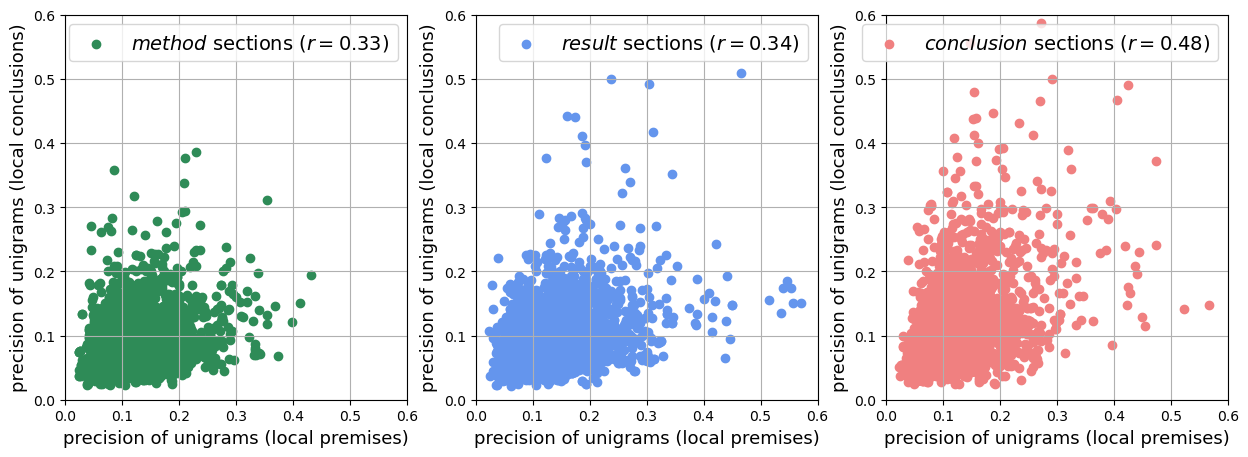

In [9]:
ax = plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(section_pre_precisions['method'], section_con_precisions['method'], color='seagreen')
plt.legend([r'$\it{method}$ sections ($r=0.33$)'], fontsize=14)
plt.xlabel('precision of unigrams (local premises)', fontsize=13)
plt.ylabel('precision of unigrams (local conclusions)', fontsize=13)
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)
plt.grid(True)

plt.subplot(132)
plt.scatter(section_pre_precisions['result'], section_con_precisions['result'], color='cornflowerblue')
plt.legend([r'$\it{result}$ sections ($r=0.34$)'], fontsize=14)
plt.xlabel('precision of unigrams (local premises)', fontsize=13)
plt.ylabel('precision of unigrams (local conclusions)', fontsize=13)
plt.grid(True)
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)

plt.subplot(133)
plt.scatter(section_pre_precisions['conclusion'], section_con_precisions['conclusion'], color='lightcoral')
plt.legend([r'$\it{conclusion}$ sections ($r=0.48$)'], fontsize=14)
plt.xlabel('precision of unigrams (local premises)', fontsize=13)
plt.ylabel('precision of unigrams (local conclusions)', fontsize=13)
plt.grid(True)
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)

plt.savefig('unigram_precisions_individual.png', dpi=300, bbox_inches='tight')

plt.show()

In [29]:
def half_round(x):
    base = int(x*10)
    rest = x*10 - base
    
    if rest < 0.5 :
        return '%.2f' % ((base + 0.5) / 10)
    
    else:
        
        return '%.2f' % ((base + 1) / 10)

In [30]:
def centi_round(x):
    base = int(x*100)
    rest = x*100 - base
    
    return '%.2f' % ((base + 1) / 100)

In [31]:
def fifth_round(x):
    base = int(x*10)
    
    if base < 2:
        return '%.2f' % (0.2)
    elif 2 <= base < 4:
        return '%.2f' % (0.4)
    elif 4 <= base < 6:
        return '%.2f' % (0.6)
    else:
        return '%.2f' % (0.0)

In [33]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [34]:
x = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
y = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]

index = {'0.00':0, '0.05':1, '0.10':2, '0.15':3, '0.20':4, '0.25':5,
         '0.30':6, '0.35':7, '0.40':8, '0.45':9, '0.50':10, '0.55':11, '0.60':12}

squares_method = np.zeros((13, 13))
squares_result = np.zeros((13, 13))
squares_conclusion = np.zeros((13, 13))

for pre, con in zip(section_pre_precisions['method'], section_con_precisions['method']):
    
    pre_grid_right_point = half_round(pre)
    con_grid_right_point = half_round(con)
    if float(pre_grid_right_point) <= 0.6 and float(con_grid_right_point) <= 0.6:
        squares_method[index[con_grid_right_point], index[pre_grid_right_point]] += 1

for pre, con in zip(section_pre_precisions['result'], section_con_precisions['result']):
    pre_grid_right_point = half_round(pre)
    con_grid_right_point = half_round(con)
    if float(pre_grid_right_point) <= 0.6 and float(con_grid_right_point) <= 0.6:
        squares_result[index[con_grid_right_point], index[pre_grid_right_point]] += 1

for pre, con in zip(section_pre_precisions['conclusion'], section_con_precisions['conclusion']):
    pre_grid_right_point = half_round(pre)
    con_grid_right_point = half_round(con)
    if float(pre_grid_right_point) <= 0.6 and float(con_grid_right_point) <= 0.6:
        squares_conclusion[index[con_grid_right_point], index[pre_grid_right_point]] += 1

In [37]:
x = np.arange(0, 0.61, 0.01)
y = np.arange(0, 0.61, 0.01)

index = dict()

index_counter = 0
for i in x:
    index['%.2f'%i] = index_counter
    index_counter += 1
    
squares_method = np.zeros((len(x), len(y)))
squares_result = np.zeros((len(x), len(y)))
squares_conclusion = np.zeros((len(x), len(y)))
                              
for pre, con in zip(section_pre_precisions['method'], section_con_precisions['method']):
    pre_grid_right_point = centi_round(pre)
    con_grid_right_point = centi_round(con)
    if float(pre_grid_right_point) <= 0.6 and float(con_grid_right_point) <= 0.6:
        squares_method[index[con_grid_right_point], index[pre_grid_right_point]] += 1

for pre, con in zip(section_pre_precisions['result'], section_con_precisions['result']):
    pre_grid_right_point = centi_round(pre)
    con_grid_right_point = centi_round(con)
    if float(pre_grid_right_point) <= 0.6 and float(con_grid_right_point) <= 0.6:
        squares_result[index[con_grid_right_point], index[pre_grid_right_point]] += 1

for pre, con in zip(section_pre_precisions['conclusion'], section_con_precisions['conclusion']):
    pre_grid_right_point = centi_round(pre)
    con_grid_right_point = centi_round(con)
    if float(pre_grid_right_point) <= 0.6 and float(con_grid_right_point) <= 0.6:
        squares_conclusion[index[con_grid_right_point], index[pre_grid_right_point]] += 1   
        
squares_method = gaussian_filter(squares_method, sigma=1) 
squares_result = gaussian_filter(squares_result, sigma=1) 
squares_conclusion = gaussian_filter(squares_conclusion, sigma=1)

In [38]:
def compute_levels(square):
    M, N = square.shape
    first_third = int(0.33 * np.sum(square))
    second_third = int(0.66 * np.sum(square))
    
    square_max = int(np.max(square))
    
    square_levels = dict()
    
    for t in range(square_max):
        square_levels[t] = 0
        for i in range(M):
            for j in range(N):
                if square[i,j] > t:
                    square_levels[t] += square[i,j]
                else:
                    continue
                    
    print(first_third, second_third)
    
    return square_levels

In [57]:
compute_levels(squares_conclusion)

783 1566


{0: 2372.999999999975,
 1: 2120.7342858063457,
 2: 1949.782716875583,
 3: 1778.2577764148596,
 4: 1632.9053757152267,
 5: 1525.567631241545,
 6: 1376.652494291504,
 7: 1252.5940479393369,
 8: 1116.1205598086403,
 9: 1013.3991189584943,
 10: 907.0744759359382,
 11: 813.0467317336295,
 12: 721.943605346263,
 13: 583.4441181376396,
 14: 489.16241655631904,
 15: 401.4528624414287,
 16: 308.3347394969995,
 17: 258.6359877835285,
 18: 153.3996784871227,
 19: 79.53723712179672}

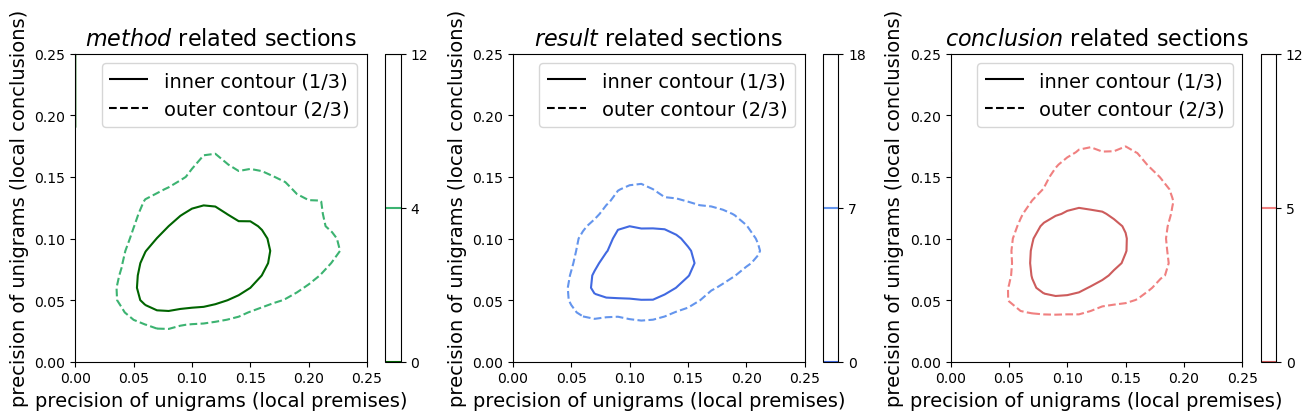

In [58]:
fig = plt.figure(figsize=(16, 4))

ax1 = plt.subplot(131)      
X, Y = np.meshgrid(x, y)
Z = squares_method
cs = plt.contour(X, Y, Z, [0, 4, 12], colors=['darkgreen', 'mediumseagreen'], linestyles=['solid', 'dashed'])
labels = ['line1', 'line2']
for i in range(len(labels)):
    cs.collections[i].set_label(labels[i])
plt.colorbar()
plt.legend(['inner contour (1/3)', 'outer contour (2/3)'], fontsize=14)

leg = ax1.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

plt.xlabel('precision of unigrams (local premises)', fontsize=14)
plt.ylabel('precision of unigrams (local conclusions)',fontsize=14)
plt.title(r'$\it{method}$ related sections', fontsize=16)
plt.xlim([0, 0.25])
plt.ylim([0, 0.25])

ax2 = plt.subplot(132)
X, Y = np.meshgrid(x, y)
Z = squares_result
cs = plt.contour(X, Y, Z, [0, 7, 18], colors=['royalblue', 'cornflowerblue'], linestyles=['solid', 'dashed'])
labels = ['line1', 'line2']
for i in range(len(labels)):
    cs.collections[i].set_label(labels[i])
plt.colorbar()
plt.title(r'$\it{result}$ related sections', fontsize=16)
plt.legend(['inner contour (1/3)', 'outer contour (2/3)'], fontsize=14)

leg = ax2.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
plt.xlabel('precision of unigrams (local premises)', fontsize=14)
plt.ylabel('precision of unigrams (local conclusions)', fontsize=14)
plt.xlim([0, 0.25])
plt.ylim([0, 0.25])

ax3 = plt.subplot(133)
X, Y = np.meshgrid(x, y)
Z = squares_conclusion
cs = plt.contour(X, Y, Z, [0, 5, 12], colors=['indianred', 'lightcoral'], linestyles=['solid', 'dashed'])
labels = ['line1', 'line2']
for i in range(len(labels)):
    cs.collections[i].set_label(labels[i])
plt.colorbar()
plt.title(r'$\it{conclusion}$ related sections', fontsize=16)
plt.legend(['inner contour (1/3)', 'outer contour (2/3)'], fontsize=14)
leg = ax3.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
plt.xlabel('precision of unigrams (local premises)', fontsize=14)
plt.ylabel('precision of unigrams (local conclusions)', fontsize=14)
plt.xlim([0, 0.25])
plt.ylim([0, 0.25])

#ax.suptitle('Contour plot for unigram precisions of individual local premises and local conclusions in different related sections')
#plt.savefig('unigram_precisions_contour_levels.png', dpi=300, bbox_inches='tight')

plt.show()

# default cmap color RdGy


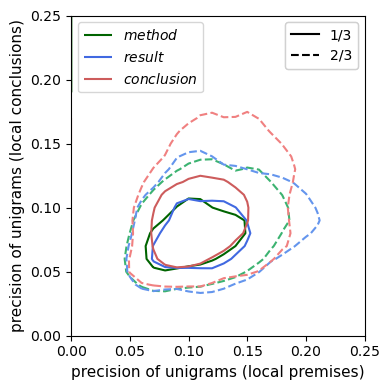

In [52]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)


X, Y = np.meshgrid(x, y)
Z1 = squares_method
Z2 = squares_result
Z3 = squares_conclusion

cs1 = ax.contour(X, Y, Z1, [0, 8, 19], colors=['darkgreen', 'mediumseagreen'], linestyles=['solid', 'dashed'])

cs1_labels = [r'$\it{method}$', 'line2']
for i in range(len(cs1_labels)):
    if i != 1:
        cs1.collections[i].set_label(cs1_labels[i])   

cs2 = ax.contour(X, Y, Z2, [0, 7, 19], colors=['royalblue', 'cornflowerblue'], linestyles=['solid', 'dashed'])

cs2_labels = [r'$\it{result}$', 'line2']
for i in range(len(cs2_labels)):
    if i != 1:
        cs2.collections[i].set_label(cs2_labels[i])

cs3 = ax.contour(X, Y, Z3, [0, 5, 12], colors=['indianred', 'lightcoral'], linestyles=['solid', 'dashed'])

cs3_labels = [r'$\it{conclusion}$', 'line2']
for i in range(len(cs3_labels)):
    if i != 1:
        cs3.collections[i].set_label(cs3_labels[i])    

plt.plot([],[], '-',color='black')
plt.plot([],[],'--', color='black')

legend1 = ax.legend(loc='upper left')  

legend2 = plt.legend(['1/3', '2/3'], loc='upper right')
leg = ax.get_legend()
plt.gca().add_artist(legend2)
plt.gca().add_artist(legend1)

plt.xlabel('precision of unigrams (local premises)', fontsize=11)
plt.ylabel('precision of unigrams (local conclusions)', fontsize=11)

plt.xlim([0, 0.25])
plt.ylim([0, 0.25])

fig.tight_layout()

plt.savefig('unigram_precisions_contour_superimposed.png', dpi=300, bbox_inches='tight')

plt.show()